In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.models import load_model

In [100]:
df = pd.read_csv('paris_temperature.csv')

In [101]:
df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Paris,France",2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,...,3.5,3,10,2023-10-01T07:49:34,2023-10-01T19:30:27,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,0715709999..."
1,"Paris,France",2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,...,4.4,4,10,2023-10-02T07:51:01,2023-10-02T19:28:21,0.60,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"07149099999,07156099999,07146099999,0715709999..."
2,"Paris,France",2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,...,4.8,4,10,2023-10-03T07:52:29,2023-10-03T19:26:16,0.63,"Rain, Partially cloudy",Partly cloudy throughout the day with rain in ...,rain,"07149099999,07156099999,07146099999,LFPV,07157..."
3,"Paris,France",2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,...,5.1,4,10,2023-10-04T07:53:57,2023-10-04T19:24:10,0.66,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."
4,"Paris,France",2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,...,3.5,3,10,2023-10-05T07:55:25,2023-10-05T19:22:06,0.70,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"07149099999,07156099999,07146099999,LFPV,07145..."


In [102]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

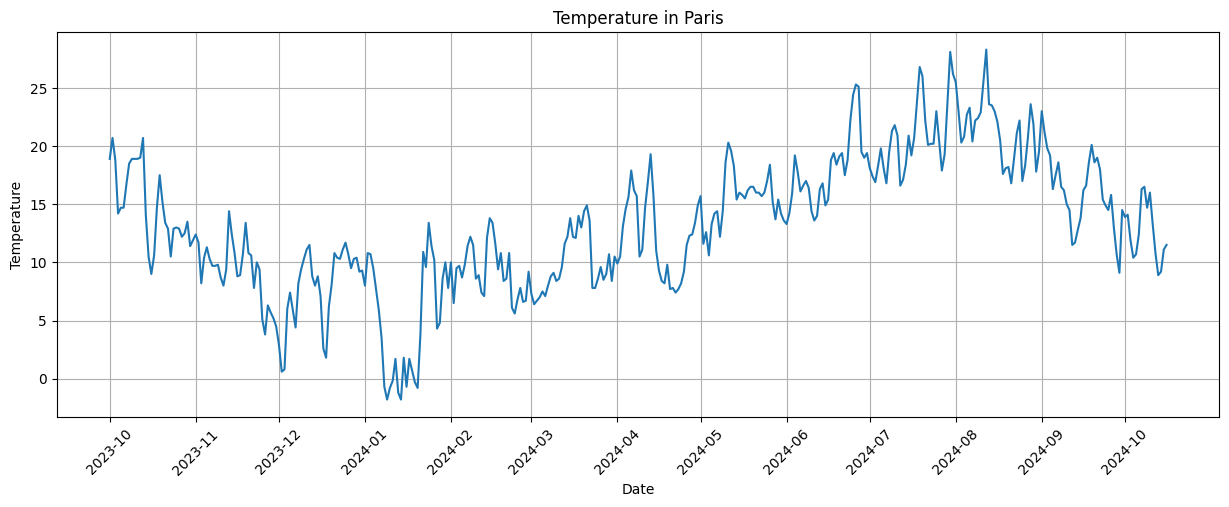

In [103]:
# 1
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['temp'])
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.show()

In [104]:
# 3
numerical_features = []
categorical_features = []
date_features = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        numerical_features.append(col)
    elif df[col].dtype == 'object':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"There are {len(numerical_features)} numerical features: {numerical_features}")
print(f"There are {len(categorical_features)} categorical features: {categorical_features}")

There are 24 numerical features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
There are 8 categorical features: ['name', 'preciptype', 'sunrise', 'sunset', 'conditions', 'description', 'icon', 'stations']


In [105]:
df_numerical = df[numerical_features]
df_numerical


,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,26.5,12.5,18.9,26.5,12.5,18.9,13.7,74.3,0.144,100.0,...,11.3,170.2,1023.7,46.5,18.6,39.8,3.5,3,10,0.57
2023-10-02,27.7,14.5,20.7,27.9,14.5,20.7,14.7,71.0,0.000,0.0,...,12.0,173.7,1018.8,48.6,16.8,51.3,4.4,4,10,0.60
2023-10-03,22.1,15.0,18.8,22.1,15.0,18.8,13.0,69.9,0.386,100.0,...,22.8,277.2,1020.5,71.8,22.1,54.5,4.8,4,10,0.63
2023-10-04,18.2,10.2,14.2,18.2,10.2,14.2,9.3,73.2,0.006,100.0,...,12.3,260.9,1029.8,62.0,22.4,58.9,5.1,4,10,0.66
2023-10-05,19.8,11.0,14.7,19.8,11.0,14.7,9.4,72.1,0.014,100.0,...,6.8,238.3,1027.3,82.3,21.3,41.7,3.5,3,10,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-12,13.5,8.1,10.8,13.5,6.6,10.3,2.7,58.9,0.000,45.2,...,13.6,223.4,1015.2,70.4,24.1,87.0,7.8,3,10,0.33
2024-10-13,11.2,7.8,8.9,11.2,4.9,6.8,4.6,75.5,3.200,38.7,...,22.0,20.7,1014.8,99.8,22.5,5.0,0.6,0,10,0.36
2024-10-14,9.9,8.0,9.2,8.9,6.1,7.8,7.3,88.1,1.100,32.3,...,14.0,278.9,1009.7,100.0,24.1,7.1,0.6,0,10,0.40


C:\Users\ADM\AppData\Local\Temp\ipykernel_21836\2490300795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical[numerical_features] = scaler.fit_transform(df_numerical[numerical_features])


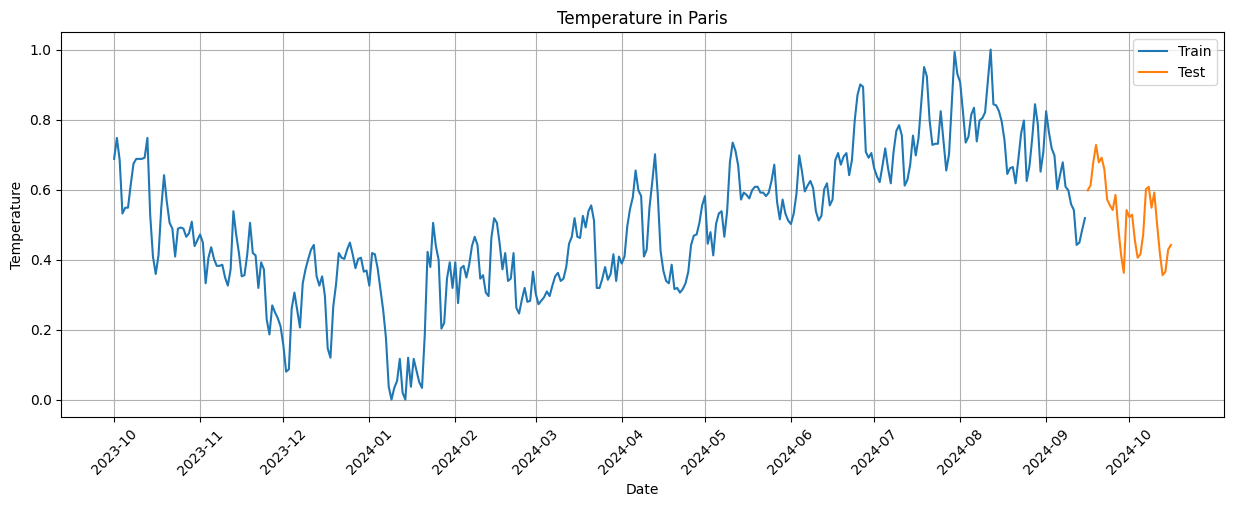

In [125]:
# 4
scaler = MinMaxScaler()
df_numerical[numerical_features] = scaler.fit_transform(df_numerical[numerical_features])
train_set = df_numerical[df_numerical.index <= pd.Timestamp('2024-09-15')]
test_set = df_numerical[df_numerical.index > pd.Timestamp('2024-09-15')]
plt.figure(figsize=(15, 5))
plt.plot(train_set.index, train_set['temp'], label='Train')
plt.plot(test_set.index, test_set['temp'], label='Test')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Temperature in Paris")
plt.xticks(pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS').to_pydatetime(), [date.strftime('%Y-%m') for date in pd.date_range(start=df_numerical.index.min(), end=df_numerical.index.max(), freq='MS')], rotation=45)
plt.grid()
plt.legend()
plt.show()

In [123]:
test_set

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2024-09-16,0.557333,0.656126,0.598007,0.564045,0.694737,0.626741,0.651515,0.476959,0.000000,0.000,...,0.298667,0.042761,0.736926,0.896552,0.538235,0.285630,0.285714,0.250,0.0,0.448980
2024-09-17,0.600000,0.703557,0.611296,0.600000,0.736842,0.637883,0.689394,0.550691,0.000280,1.000,...,0.469333,0.098099,0.722662,0.748276,0.473529,0.349234,0.353741,0.500,0.0,0.489796
2024-09-18,0.669333,0.715415,0.677741,0.658427,0.747368,0.693593,0.731061,0.486175,0.000000,0.000,...,0.373333,0.127446,0.665610,0.429885,0.267647,1.000000,1.000000,0.875,0.0,0.510204
2024-09-19,0.717333,0.762846,0.727575,0.698876,0.789474,0.735376,0.681818,0.230415,0.000000,0.000,...,0.416000,0.171884,0.614897,0.247126,0.335294,0.308598,0.292517,0.500,0.0,0.551020
2024-09-20,0.674667,0.727273,0.677741,0.662921,0.757895,0.693593,0.700758,0.373272,0.004798,1.000,...,0.218667,0.233091,0.592710,0.619540,0.429412,0.279741,0.278912,0.375,0.0,0.591837
2024-09-21,0.664000,0.750988,0.691030,0.653933,0.778947,0.704735,0.776515,0.557604,0.041947,1.000,...,0.176000,0.370878,0.587956,0.802299,0.473529,0.220848,0.217687,0.250,0.0,0.622449
2024-09-22,0.568000,0.798419,0.657807,0.573034,0.821053,0.676880,0.829545,0.820276,0.363004,1.000,...,0.186667,0.477641,0.526149,0.989655,0.267647,0.159600,0.163265,0.125,0.0,0.663265
2024-09-23,0.512000,0.699605,0.571429,0.525843,0.733333,0.604457,0.746212,0.877880,0.127959,1.000,...,0.328000,0.553661,0.458003,0.913793,0.135294,0.207303,0.197279,0.125,0.0,0.693878
2024-09-24,0.485333,0.711462,0.554817,0.503371,0.743860,0.590529,0.738636,0.903226,0.163948,1.000,...,0.392000,0.633035,0.419968,0.973563,0.138235,0.217903,0.210884,0.250,0.0,0.765306


In [126]:
train_set

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01,0.741333,0.656126,0.687708,0.719101,0.694737,0.701950,0.750000,0.523041,0.005758,1.0,...,0.120000,0.474567,0.697306,0.385057,0.397059,0.234393,0.238095,0.375,0.0,0.581633
2023-10-02,0.773333,0.735178,0.747508,0.750562,0.764912,0.752089,0.787879,0.447005,0.000000,0.0,...,0.138667,0.484349,0.619651,0.409195,0.344118,0.302120,0.299320,0.500,0.0,0.612245
2023-10-03,0.624000,0.754941,0.684385,0.620225,0.782456,0.699164,0.723485,0.421659,0.015435,1.0,...,0.426667,0.773617,0.646593,0.675862,0.500000,0.320966,0.326531,0.500,0.0,0.642857
2023-10-04,0.520000,0.565217,0.531561,0.532584,0.614035,0.571031,0.583333,0.497696,0.000240,1.0,...,0.146667,0.728060,0.793978,0.563218,0.508824,0.346879,0.346939,0.500,0.0,0.673469
2023-10-05,0.562667,0.596838,0.548173,0.568539,0.642105,0.584958,0.587121,0.472350,0.000560,1.0,...,0.000000,0.664897,0.754358,0.796552,0.476471,0.245583,0.238095,0.375,0.0,0.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-11,0.485333,0.624506,0.541528,0.503371,0.666667,0.579387,0.583333,0.486175,0.057502,1.0,...,0.490667,0.783119,0.502377,0.789655,0.464706,0.351590,0.340136,0.375,0.0,0.255102
2024-09-12,0.437333,0.501976,0.441860,0.462921,0.508772,0.484680,0.492424,0.529954,0.222569,1.0,...,0.250667,0.812465,0.576862,0.418391,0.535294,0.257362,0.251701,0.500,0.0,0.316327
2024-09-13,0.461333,0.458498,0.448505,0.483146,0.480702,0.484680,0.511364,0.550691,0.000000,0.0,...,0.365333,0.937395,0.725832,0.641379,0.441176,0.296231,0.306122,0.375,0.0,0.346939


# Question 7
### (a) Applying LSTM model

In [107]:
def create_features_and_labels(data, feature_columns, target_column, window=1):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[feature_columns].iloc[i:i + window].values)
        y.append(data[target_column].iloc[i + window])
    return np.array(X), np.array(y)

feature_columns = ['dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']  
target_column = 'temp'  
window_size = 4

X_train, y_train = create_features_and_labels(train_set, feature_columns, target_column, window=window_size)
X_test, y_test = create_features_and_labels(test_set, feature_columns, target_column, window=window_size)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (347, 4, 18)
y_train shape: (347,)
X_test shape: (27, 4, 18)
y_test shape: (27,)


In [108]:
X_train.dtype

dtype('float64')

In [ ]:
optimizer = Adam(learning_rate=5e-3)
callback = EarlyStopping(monitor='loss', patience=3)

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) 
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25, kernel_regularizer='l2'))  
model.add(Dense(1))  
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=4, epochs=150, validation_data=(X_test, y_test), callbacks=[callback])
model.save("best_model.keras")

Epoch 1/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9308 - val_loss: 0.3009
Epoch 2/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4026 - val_loss: 0.2553
Epoch 3/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2967 - val_loss: 0.1962
Epoch 4/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2158 - val_loss: 0.2538
Epoch 5/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1933 - val_loss: 0.2156
Epoch 6/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1797 - val_loss: 0.2169
Epoch 7/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1503 - val_loss: 0.1614
Epoch 8/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1306 - val_loss: 0.1973
Epoch 9/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1234 - val_loss: 0.4074
Epoch 10/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1555 - val_loss: 0.2516
Epoch 11/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1145 - val_loss: 0.1700
Epoch 12/150
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1

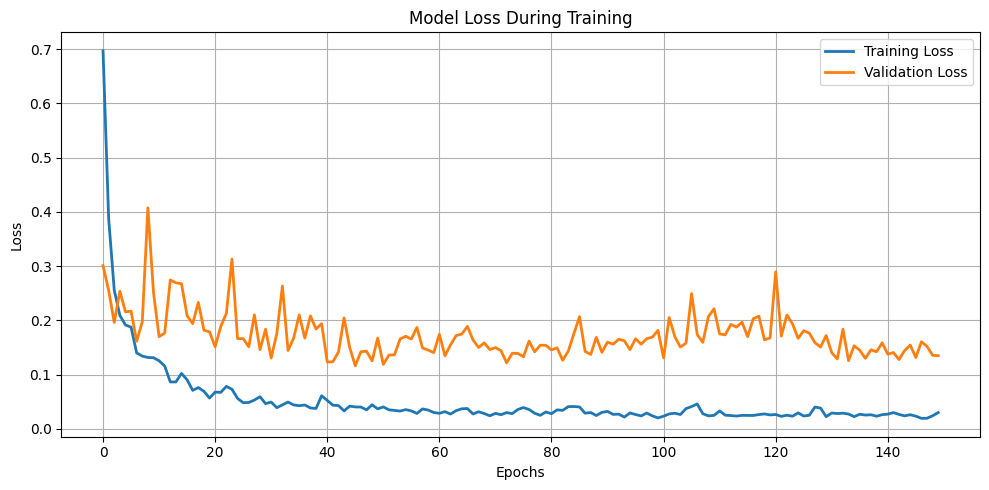

In [112]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


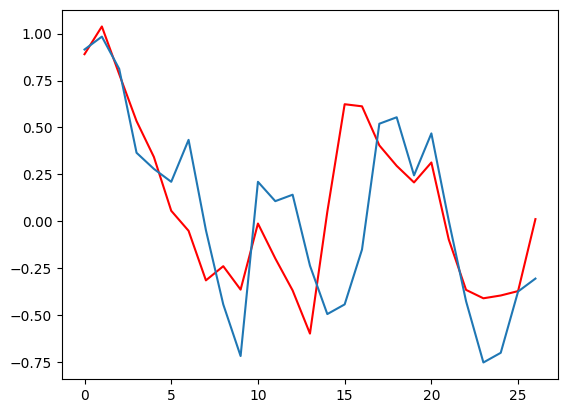

In [117]:
y_pred = model.predict(X_test)
plt.plot(y_pred, color = "r")
plt.plot(y_test)

In [114]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MSE: 0.1303757962348018
MAE: 0.26951690131684075
RMSE: 0.3610758870858061


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
             Feature  Importance
1           humidity    0.015602
4        precipcover    0.012904
9            winddir    0.002153
10  sealevelpressure    0.001258
16        severerisk    0.000000
5               snow    0.000000
6          snowdepth    0.000000
12        vis

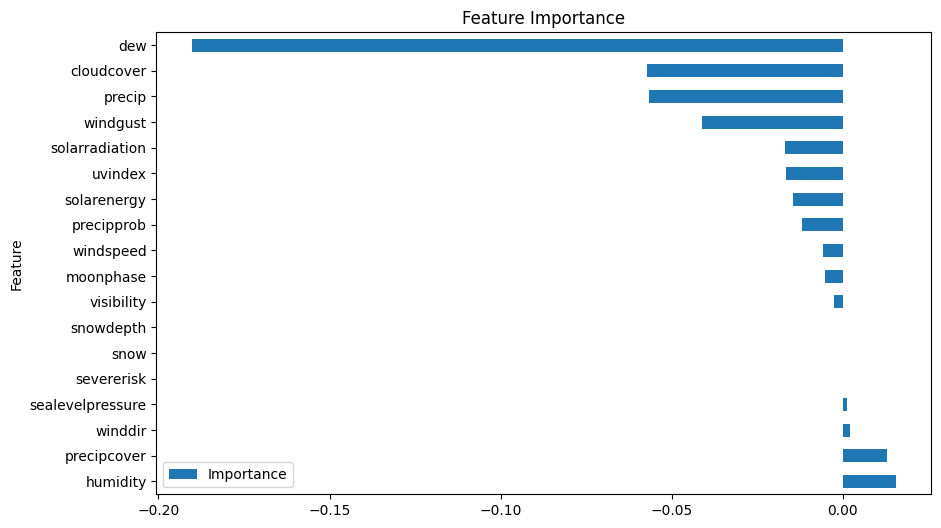

In [115]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to compute permutation importance
def permutation_importance(model, X, y, metric=mean_squared_error):
    baseline_score = metric(y, model.predict(X).squeeze())
    importances = []

    for col in range(X.shape[2]):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, :, col])  # Shuffle the specific feature
        permuted_score = metric(y, model.predict(X_permuted).squeeze())
        importance = baseline_score - permuted_score
        importances.append(importance)

    return np.array(importances)

# Compute feature importance for your LSTM model
feature_importances = permutation_importance(model, X_test, y_test)

# Map importance scores to feature names
feature_names = feature_columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot the feature importances
importance_df.plot(kind='barh', x='Feature', y='Importance', figsize=(10, 6), title='Feature Importance')
plt.show()


### (b) Find the best possible configuration for RMSE on testset

In [116]:
# hidden_sizes = [32, 64, 128]
# num_layers = [1, 2, 3]
# learning_rates = [0.01, 0.001, 0.0005]
# batch_sizes = [16, 32]
# lookbacks = [5, 7]

# best_rmse = float("inf")
# best_config = None
# best_model_path = "best_lstm_model.pth" 

# def evaluate_model(model, test_loader):
#     model.eval()
#     predictions, actuals = [], []
#     with torch.no_grad():
#         for batch in test_loader:
#             x_batch, y_batch = batch[0].to(device).float(), batch[1].to(device).float()
#             output = model(x_batch)
#             predictions.extend(output.cpu().numpy())
#             actuals.extend(y_batch.cpu().numpy())
#     rmse = np.sqrt(mean_squared_error(actuals, predictions))
#     return rmse

# for hidden_size, num_layer, lr, batch_size, lookback in product(hidden_sizes, num_layers, learning_rates, batch_sizes, lookbacks):
#     model = LSTM(input_size=22, hidden_size=hidden_size, num_stacked_layers=num_layer).to(device)
#     loss_function = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#     num_epochs = 10
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for batch_index, batch in enumerate(train_loader):
#             x_batch, y_batch = batch[0].to(device).float(), batch[1].to(device).float()
#             output = model(x_batch)
#             loss = loss_function(output, y_batch)
#             running_loss += loss.item()
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#     rmse = evaluate_model(model, test_loader)
#     print(f"Config: hidden_size={hidden_size}, num_layer={num_layer}, lr={lr}, batch_size={batch_size}, lookback={lookback} -> RMSE: {rmse:.3f}")

#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_config = {
#             "hidden_size": hidden_size,
#             "num_layer": num_layer,
#             "learning_rate": lr,
#             "batch_size": batch_size,
#             "lookback": lookback
#         }
#         torch.save(model.state_dict(), best_model_path)
#         print(f"New best model saved with RMSE: {best_rmse:.3f}")

# print("Best Configuration:", best_config)
# print("Best RMSE:", best_rmse)

# best_model = LSTM(input_size=22, hidden_size=best_config['hidden_size'], num_stacked_layers=best_config['num_layer']).to(device)
# best_model.load_state_dict(torch.load(best_model_path))
# best_model.eval() 

# rmse = evaluate_model(best_model, test_loader)
# print(f"Final RMSE on Test Set with Best Model: {rmse:.3f}")

# predictions, actuals = [], []
# with torch.no_grad():
#     for batch in test_loader:
#         x_batch, y_batch = batch[0].to(device).float(), batch[1].to(device).float()
#         output = best_model(x_batch)
#         predictions.extend(output.cpu().numpy())
#         actuals.extend(y_batch.cpu().numpy())

# plt.figure(figsize=(10, 6))
# plt.plot(actuals, label='Actual Temperature', color='b')
# plt.plot(predictions, label='Predicted Temperature', color='orange')
# plt.title('Actual vs Predicted Temperature (Best Model)')
# plt.xlabel('Time Steps')
# plt.ylabel('Temperature')
# plt.legend()
# plt.show()
